In [1]:
# Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import warnings
warnings.filterwarnings("ignore")  # optional: suppress all warnings

In [2]:
# Load and Inspect Dataset

data = pd.read_csv("oral_cancer_prediction_preprocessed_dataset_new.csv")

print("Dataset shape:", data.shape)
print("\nColumns:\n", data.columns.tolist())
print("\nTarget distribution:")
print(data["Oral Cancer (Diagnosis)"].value_counts())

Dataset shape: (82715, 16)

Columns:
 ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'Oral Cancer (Diagnosis)']

Target distribution:
Oral Cancer (Diagnosis)
1    42968
0    39747
Name: count, dtype: int64


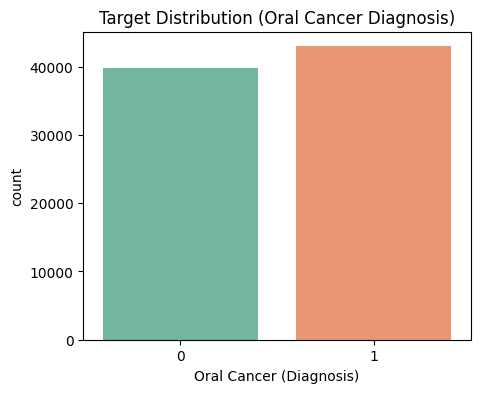

In [3]:
# Target distribution visualization

plt.figure(figsize=(5,4))
sns.countplot(x="Oral Cancer (Diagnosis)", data=data, palette="Set2")
plt.title("Target Distribution (Oral Cancer Diagnosis)")
plt.show()

In [4]:
# Split Features and Target

X = data.drop("Oral Cancer (Diagnosis)", axis=1)
y = data["Oral Cancer (Diagnosis)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
# Feature Scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Helper Function for Evaluation & Visualization

def evaluate_model(model, X_test, y_test, kernel_name):
    """Evaluate SVM model and plot confusion matrix + ROC curve."""
    # Use decision_function for ROC (no probability=True needed)
    y_pred = model.predict(X_test)
    y_score = model.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_score)
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_score)

    print(f"\n--- {kernel_name.upper()} RESULTS ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))  # Fixed warning

    # Confusion Matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {kernel_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{kernel_name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve - {kernel_name}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return acc, f1, auc, fpr, tpr

## TRAINING MODELS (Default Parameters)

Training Linear Kernel SVM ...

--- LINEAR KERNEL RESULTS ---
Accuracy: 0.5066
F1 Score: 0.5168
AUC: 0.5044

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      7949
           1       0.53      0.51      0.52      8594

    accuracy                           0.51     16543
   macro avg       0.51      0.51      0.51     16543
weighted avg       0.51      0.51      0.51     16543



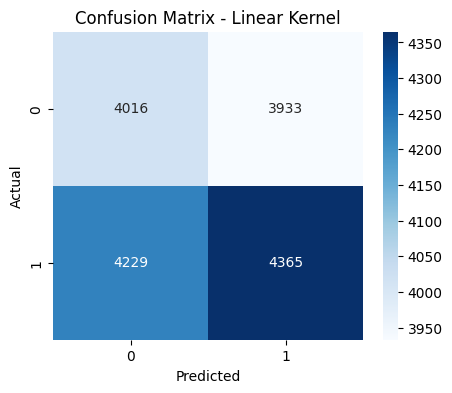

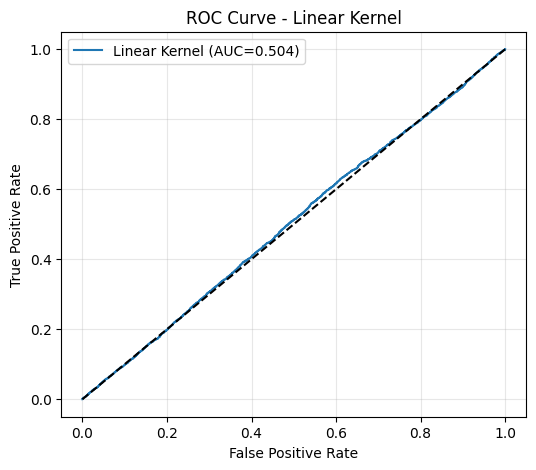

In [7]:
# Train and Evaluate Linear Kernel

print("Training Linear Kernel SVM ...")
svm_linear = SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42)
svm_linear.fit(X_train_scaled, y_train)

acc_linear, f1_linear, auc_linear, fpr_linear, tpr_linear = evaluate_model(
    svm_linear, X_test_scaled, y_test, "Linear Kernel"
)

Training RBF Kernel SVM ...

--- RBF KERNEL RESULTS ---
Accuracy: 0.5064
F1 Score: 0.5347
AUC: 0.5032

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.46      0.47      7949
           1       0.52      0.55      0.53      8594

    accuracy                           0.51     16543
   macro avg       0.50      0.50      0.50     16543
weighted avg       0.51      0.51      0.51     16543



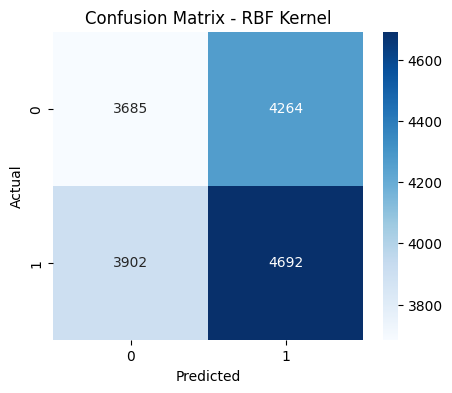

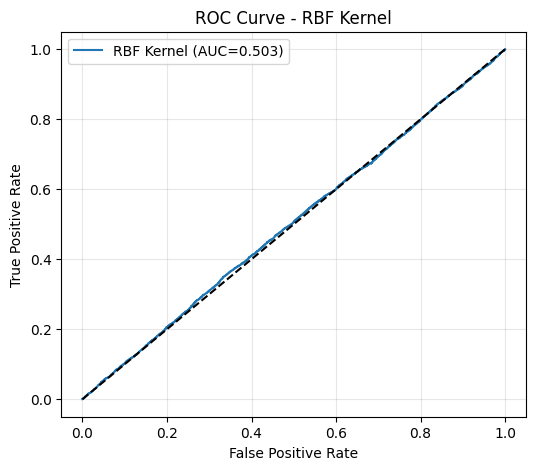

In [8]:
# Train and Evaluate RBF Kernel

print("Training RBF Kernel SVM ...")
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42)
svm_rbf.fit(X_train_scaled, y_train)

acc_rbf, f1_rbf, auc_rbf, fpr_rbf, tpr_rbf = evaluate_model(
    svm_rbf, X_test_scaled, y_test, "RBF Kernel"
)

Training Polynomial Kernel SVM ...

--- POLYNOMIAL KERNEL RESULTS ---
Accuracy: 0.5073
F1 Score: 0.5306
AUC: 0.5114

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.48      0.48      7949
           1       0.53      0.54      0.53      8594

    accuracy                           0.51     16543
   macro avg       0.51      0.51      0.51     16543
weighted avg       0.51      0.51      0.51     16543



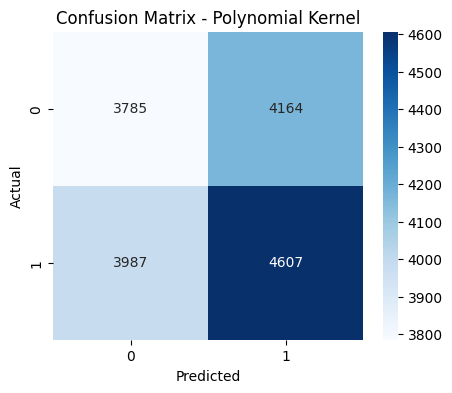

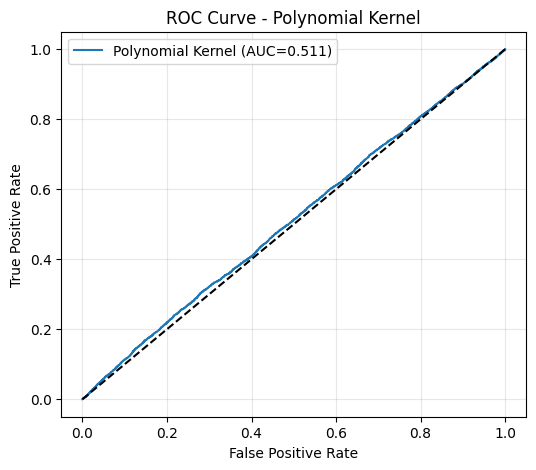

In [9]:
# Train and Evaluate Polynomial Kernel

print("Training Polynomial Kernel SVM ...")
svm_poly = SVC(kernel='poly', degree=2, C=1.0, gamma='scale', class_weight='balanced', random_state=42)
svm_poly.fit(X_train_scaled, y_train)

acc_poly, f1_poly, auc_poly, fpr_poly, tpr_poly = evaluate_model(
    svm_poly, X_test_scaled, y_test, "Polynomial Kernel"
)

In [10]:
# Comparison of Default Models

# Check if RBF variables are defined, otherwise set to None or a default value
acc_rbf = acc_rbf if 'acc_rbf' in locals() else None
f1_rbf = f1_rbf if 'f1_rbf' in locals() else None
auc_rbf = auc_rbf if 'auc_rbf' in locals() else None

default_df = pd.DataFrame({
    'Kernel': ['Linear', 'RBF', 'Polynomial'],
    'Accuracy': [acc_linear, acc_rbf, acc_poly],
    'F1 Score': [f1_linear, f1_rbf, f1_poly],
    'AUC': [auc_linear, auc_rbf, auc_poly]
})
print("\n=== DEFAULT MODEL RESULTS ===")
print(default_df.round(4))


=== DEFAULT MODEL RESULTS ===
       Kernel  Accuracy  F1 Score     AUC
0      Linear    0.5066    0.5168  0.5044
1         RBF    0.5064    0.5347  0.5032
2  Polynomial    0.5073    0.5306  0.5114


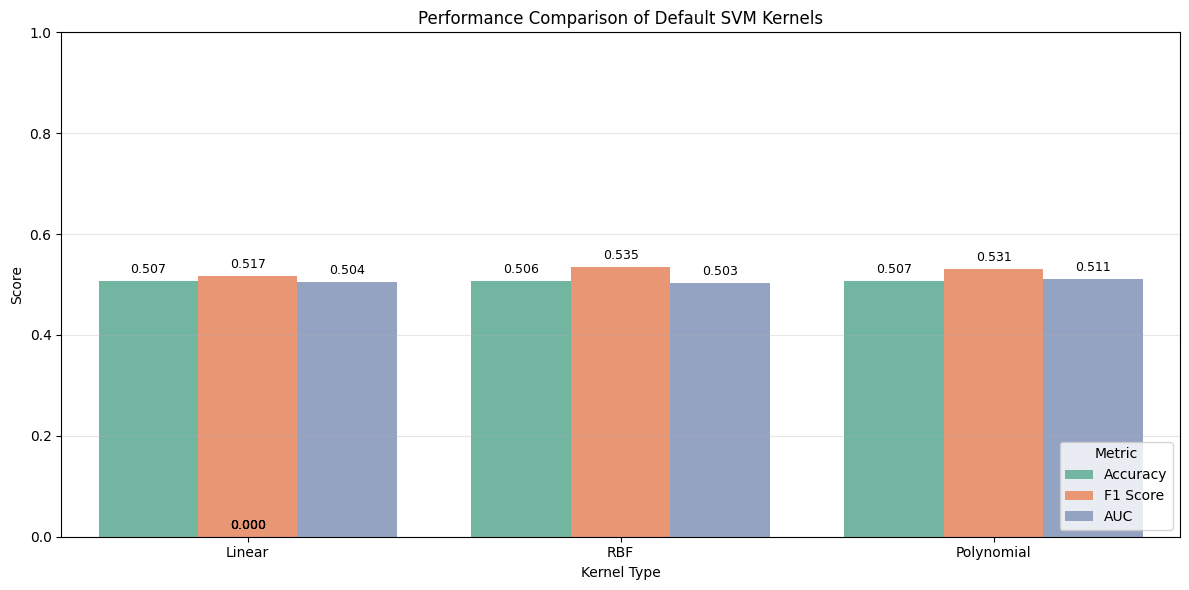

In [11]:
# Visualization: Default SVM Kernel Performance

plt.figure(figsize=(12,6))

# Melt the dataframe for easy plotting with Seaborn
default_melted = default_df.melt(id_vars='Kernel', var_name='Metric', value_name='Score')

# Create barplot
sns.barplot(data=default_melted, x='Kernel', y='Score', hue='Metric', palette='Set2')

# Add value labels on bars
for i, bar in enumerate(plt.gca().patches):
    plt.gca().text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f'{bar.get_height():.3f}',
        ha='center', va='bottom', fontsize=9
    )

plt.ylim(0, 1)
plt.title("Performance Comparison of Default SVM Kernels")
plt.xlabel("Kernel Type")
plt.ylabel("Score")
plt.legend(title="Metric", loc="lower right")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## HYPERPARAMETER TUNING (GridSearchCV)

In [12]:
cv_folds = 2  # Faster
subset_ratio = 1.0  # Use <1.0 if dataset is very large

X_tune = X_train_scaled[:int(len(X_train_scaled)*subset_ratio)]
y_tune = y_train[:int(len(y_train)*subset_ratio)]


Tuning Linear Kernel SVM ...
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 33086
max_resources_: 66172
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 3
n_resources: 33086
Fitting 2 folds for each of 3 candidates, totalling 6 fits
----------
iter: 1
n_candidates: 2
n_resources: 66172
Fitting 2 folds for each of 2 candidates, totalling 4 fits

--- LINEAR KERNEL (TUNED) RESULTS ---
Accuracy: 0.5000
F1 Score: 0.5094
AUC: 0.5031

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.50      0.49      7949
           1       0.52      0.50      0.51      8594

    accuracy                           0.50     16543
   macro avg       0.50      0.50      0.50     16543
weighted avg       0.50      0.50      0.50     16543



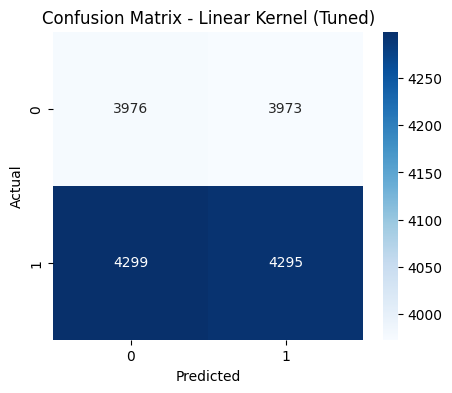

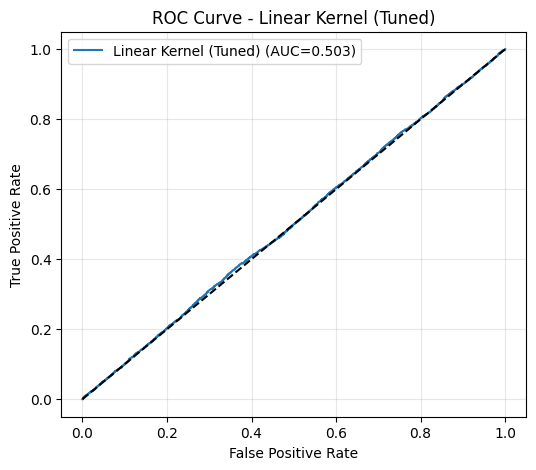

In [13]:
# Linear Kernel Tuning

print("\nTuning Linear Kernel SVM ...")
param_grid_linear = {'C': [0.1, 1, 10]}
halving_linear = HalvingGridSearchCV(
    LinearSVC(max_iter=5000, class_weight='balanced', random_state=42),
    param_grid_linear,
    scoring='f1',
    cv=cv_folds,
    factor=2,
    n_jobs=-1,
    verbose=3
)
halving_linear.fit(X_tune, y_tune)
best_linear_model = halving_linear.best_estimator_
acc_linear_t, f1_linear_t, auc_linear_t, fpr_linear_t, tpr_linear_t = evaluate_model(
    best_linear_model, X_test_scaled, y_test, "Linear Kernel (Tuned)"
)


Tuning RBF Kernel SVM ...
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 16543
max_resources_: 66172
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 16543
Fitting 2 folds for each of 4 candidates, totalling 8 fits
----------
iter: 1
n_candidates: 2
n_resources: 33086
Fitting 2 folds for each of 2 candidates, totalling 4 fits
----------
iter: 2
n_candidates: 1
n_resources: 66172
Fitting 2 folds for each of 1 candidates, totalling 2 fits

--- RBF KERNEL (TUNED) RESULTS ---
Accuracy: 0.5064
F1 Score: 0.5347
AUC: 0.5032

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.46      0.47      7949
           1       0.52      0.55      0.53      8594

    accuracy                           0.51     16543
   macro avg       0.50      0.50      0.50     16543
weighted avg       0.51      0.51      0.51     16543



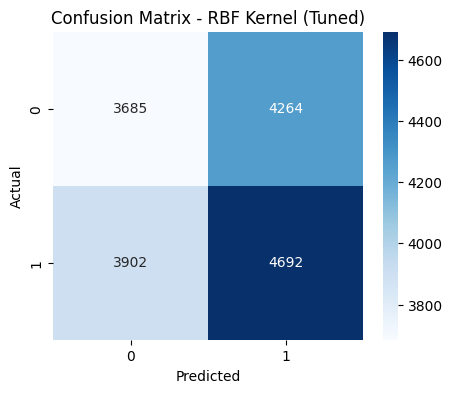

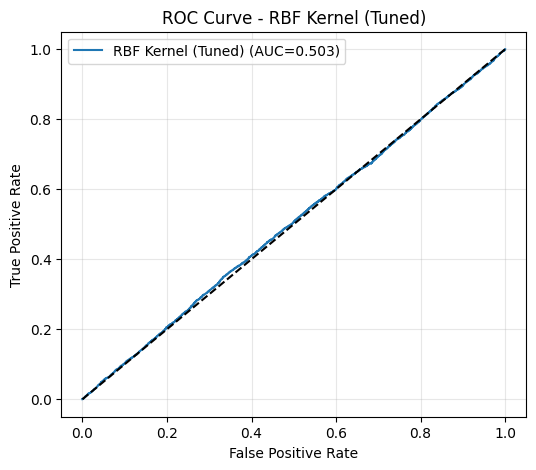

In [14]:
# RBF Kernel Tuning

print("\nTuning RBF Kernel SVM ...")
param_grid_rbf = {'C':[1,10], 'gamma':['scale',0.1], 'kernel':['rbf']}
halving_rbf = HalvingGridSearchCV(
    SVC(class_weight='balanced', random_state=42),
    param_grid_rbf,
    scoring='f1',
    cv=cv_folds,
    factor=2,
    n_jobs=-1,
    verbose=3
)
halving_rbf.fit(X_tune, y_tune)
best_rbf_model = halving_rbf.best_estimator_
acc_rbf_t, f1_rbf_t, auc_rbf_t, fpr_rbf_t, tpr_rbf_t = evaluate_model(
    best_rbf_model, X_test_scaled, y_test, "RBF Kernel (Tuned)"
)


Tuning Polynomial Kernel SVM ...
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 33086
max_resources_: 66172
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 2
n_resources: 33086
Fitting 2 folds for each of 2 candidates, totalling 4 fits
----------
iter: 1
n_candidates: 1
n_resources: 66172
Fitting 2 folds for each of 1 candidates, totalling 2 fits

--- POLYNOMIAL KERNEL (TUNED) RESULTS ---
Accuracy: 0.5073
F1 Score: 0.5306
AUC: 0.5114

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.48      0.48      7949
           1       0.53      0.54      0.53      8594

    accuracy                           0.51     16543
   macro avg       0.51      0.51      0.51     16543
weighted avg       0.51      0.51      0.51     16543



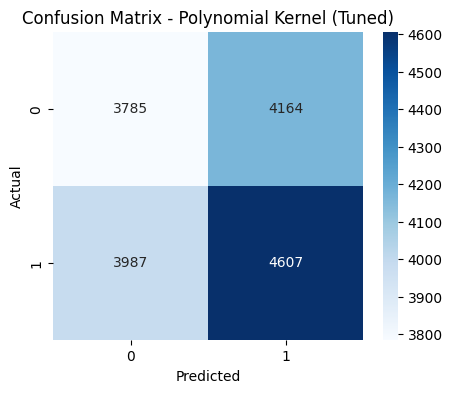

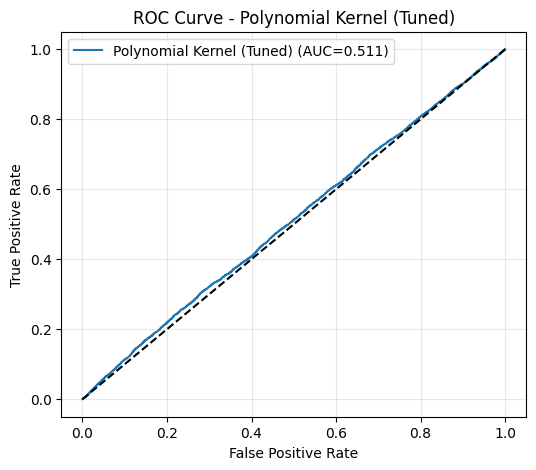

In [15]:
# Polynomial Kernel Tuning

print("\nTuning Polynomial Kernel SVM ...")
param_grid_poly = {'C':[1,10], 'degree':[2], 'gamma':['scale'], 'kernel':['poly']}
halving_poly = HalvingGridSearchCV(
    SVC(class_weight='balanced', random_state=42),
    param_grid_poly,
    scoring='f1',
    cv=cv_folds,
    factor=2,
    n_jobs=-1,
    verbose=3
)
halving_poly.fit(X_tune, y_tune)
best_poly_model = halving_poly.best_estimator_
acc_poly_t, f1_poly_t, auc_poly_t, fpr_poly_t, tpr_poly_t = evaluate_model(
    best_poly_model, X_test_scaled, y_test, "Polynomial Kernel (Tuned)"
)

## FINAL COMPARISON AND RESULTS

In [16]:
comparison_df = pd.DataFrame({
    'Kernel': ['Linear', 'RBF', 'Polynomial', 'Linear (Tuned)', 'RBF (Tuned)', 'Polynomial (Tuned)'],
    'Accuracy': [acc_linear, acc_rbf, acc_poly, acc_linear_t, acc_rbf_t, acc_poly_t],
    'F1 Score': [f1_linear, f1_rbf, f1_poly, f1_linear_t, f1_rbf_t, f1_poly_t],
    'AUC': [auc_linear, auc_rbf, auc_poly, auc_linear_t, auc_rbf_t, auc_poly_t]
})
print("\n==============================")
print(" FINAL COMPARISON OF ALL MODELS ")
print("==============================")
print(comparison_df.round(4))


 FINAL COMPARISON OF ALL MODELS 
               Kernel  Accuracy  F1 Score     AUC
0              Linear    0.5066    0.5168  0.5044
1                 RBF    0.5064    0.5347  0.5032
2          Polynomial    0.5073    0.5306  0.5114
3      Linear (Tuned)    0.5000    0.5094  0.5031
4         RBF (Tuned)    0.5064    0.5347  0.5032
5  Polynomial (Tuned)    0.5073    0.5306  0.5114


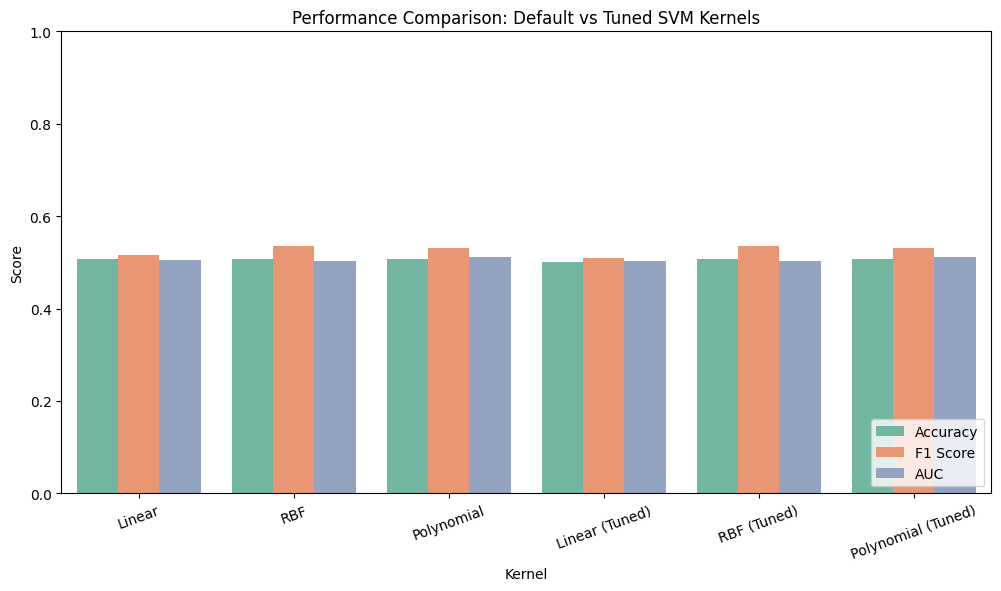

In [17]:
# Visualization

plt.figure(figsize=(12,6))
sns.barplot(data=comparison_df.melt(id_vars='Kernel', var_name='Metric', value_name='Score'),
            x='Kernel', y='Score', hue='Metric', palette='Set2')
plt.ylim(0,1)
plt.title("Performance Comparison: Default vs Tuned SVM Kernels")
plt.xticks(rotation=20)
plt.legend(loc='lower right')
plt.show()

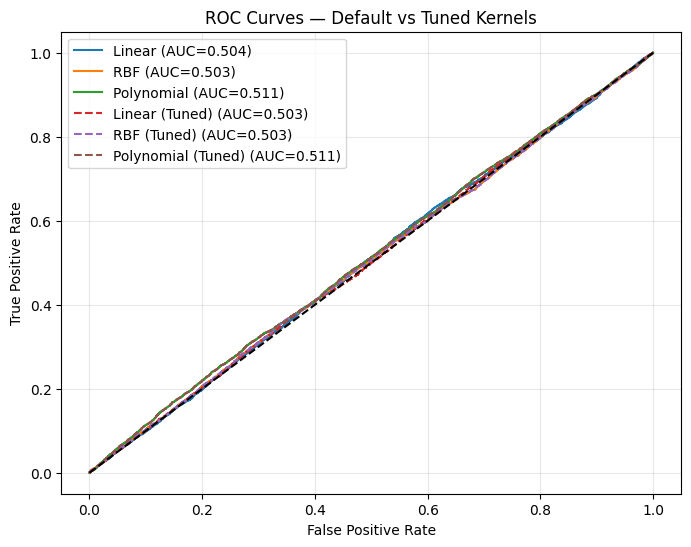

In [18]:
# Combined ROC Curves

plt.figure(figsize=(8,6))
plt.plot(fpr_linear, tpr_linear, label=f'Linear (AUC={auc_linear:.3f})')
plt.plot(fpr_rbf, tpr_rbf, label=f'RBF (AUC={auc_rbf:.3f})')
plt.plot(fpr_poly, tpr_poly, label=f'Polynomial (AUC={auc_poly:.3f})')
plt.plot(fpr_linear_t, tpr_linear_t, label=f'Linear (Tuned) (AUC={auc_linear_t:.3f})', linestyle='--')
plt.plot(fpr_rbf_t, tpr_rbf_t, label=f'RBF (Tuned) (AUC={auc_rbf_t:.3f})', linestyle='--')
plt.plot(fpr_poly_t, tpr_poly_t, label=f'Polynomial (Tuned) (AUC={auc_poly_t:.3f})', linestyle='--')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves — Default vs Tuned Kernels')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [19]:
# Identify the Best Kernel

best_kernel_auc = comparison_df.loc[comparison_df['AUC'].idxmax(), 'Kernel']
best_kernel_f1  = comparison_df.loc[comparison_df['F1 Score'].idxmax(), 'Kernel']
print(f"\nBest Kernel by AUC : {best_kernel_auc}")
print(f"Best Kernel by F1  : {best_kernel_f1}")


Best Kernel by AUC : Polynomial
Best Kernel by F1  : RBF


In [20]:
# Save Summary Table (for group comparison)

comparison_df.to_csv("svm_default_and_tuned_results.csv", index=False)
print("\nResults saved to 'svm_default_and_tuned_results.csv'")


Results saved to 'svm_default_and_tuned_results.csv'
